In [2]:
:dep plotly = { version = ">=0.6.0", features = ["plotly_ndarray"] }
:dep itertools-num = "0.1.3"
:dep ndarray = "0.15.4"
:dep polars ={ version = "0.19.0", features = ["ndarray"] }

In [3]:
use std::env;

use polars::prelude::*;
use plotly::common::{
    ColorScale, ColorScalePalette, DashType, Fill, Font, Line, LineShape, Marker, Mode, Title,
};
use plotly::{Bar, NamedColor, Plot, Rgb, Rgba, Scatter};
use plotly::layout::{Axis, BarMode, Layout, Legend, TicksDirection};

In [4]:
env::set_var("POLARS_FMT_MAX_COLS", "50");
env::set_var("POLARS_TABLE_WIDTH", "100");

In [5]:
let mut df = CsvReader::from_path("covid_19_indonesia_time_series_all.csv")?
            .with_ignore_parser_errors(true)
            .infer_schema(None)
            .has_header(true)
            .finish()?;

In [6]:
df.head(Some(5))

shape: (5, 38)
+----------+-------------------+-------------+-----------+------------+---------------+------------------+-------------+--------------+-----------------+--------------------+----------------+-----------------+-------------+-----------+-----------+----------+-----------+------------------------+-----------------+--------------+-----------------+----------------------+----------------------+------------+------------+--------------------+------------+-----------+-----------------------+-------------------------+------------------------+--------------------------+------------------------+--------------------+---------------------+----------------------------+-----------------------------+
| Date     | Location ISO Code | Location    | New Cases | New Deaths | New Recovered | New Active Cases | Total Cases | Total Deaths | Total Recovered | Total Active Cases | Location Level | City or Regency | Province    | Country   | Continent | Island   | Time Zone | Special Status      

In [7]:
df.get_column_names()

["Date", "Location ISO Code", "Location", "New Cases", "New Deaths", "New Recovered", "New Active Cases", "Total Cases", "Total Deaths", "Total Recovered", "Total Active Cases", "Location Level", "City or Regency", "Province", "Country", "Continent", "Island", "Time Zone", "Special Status", "Total Regencies", "Total Cities", "Total Districts", "Total Urban Villages", "Total Rural Villages", "Area (km2)", "Population", "Population Density", "Longitude", "Latitude", "New Cases per Million", "Total Cases per Million", "New Deaths per Million", "Total Deaths per Million", "Total Deaths per 100rb", "Case Fatality Rate", "Case Recovered Rate", "Growth Factor of New Cases", "Growth Factor of New Deaths"]

In [8]:
df.dtypes()

[Utf8, Utf8, Utf8, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Utf8, Utf8, Utf8, Utf8, Utf8, Utf8, Utf8, Utf8, Int64, Int64, Int64, Int64, Int64, Int64, Int64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Float64, Utf8, Utf8, Float64, Float64]

In [9]:
df.shape()

(21759, 38)

In [10]:
df.column("Location Level").unwrap().unique()

Ok(shape: (2,)
Series: 'Location Level' [str]
[
	"Province"
	"Country"
])

## **Analyze Data Based `Location Level: Provinces`**

In [11]:
/* get only latest provinces data by sort using date & drop_duplicates */
let provinces = df
        .filter(&df.column("Location Level").unwrap().equal("Province"))
        .unwrap()
        .sort(&["Date"], true)
        .unwrap()
        .drop_duplicates(true, Some(&["Province".to_string()]))
        .unwrap();

In [12]:
provinces

shape: (34, 38)
+----------+-------------------+------------------+-----------+------------+---------------+------------------+-------------+--------------+-----------------+--------------------+----------------+-----------------+------------------+-----------+-----------+---------------+-----------+----------------+-----------------+--------------+-----------------+----------------------+----------------------+------------+------------+--------------------+------------+-----------+-----------------------+-------------------------+------------------------+--------------------------+------------------------+--------------------+---------------------+----------------------------+-----------------------------+
| Date     | Location ISO Code | Location         | New Cases | New Deaths | New Recovered | New Active Cases | Total Cases | Total Deaths | Total Recovered | Total Active Cases | Location Level | City or Regency | Province         | Country   | Continent | Island        | Time Zone

In [13]:
// Top 5 Provinces with Most Death Cases
let top_death_provinces = provinces
    .sort(&["Total Deaths"], true)
    .unwrap()
    .head(Some(5));

//println!("{:?}", top_death_provinces);

In [14]:
// Top 5 Provinces with Most Cases
let top_cases_province = provinces
    .sort(&["Total Cases"], true)
    .unwrap()
    .head(Some(5));
//println!("{:?}", top_cases_province);

In [15]:
// Top 5 Provinces with Recovered Cases
let top_recovered_province = provinces
    .sort(&["Total Recovered"], true)
    .unwrap()
    .head(Some(5));
//println!("{:?}", top_recovered_province);

#### **Bar Chart - Traces Data & Display**

In [16]:
let top_death_trace = Bar::new(
    top_death_provinces
        .column("Province")
        .unwrap()
        .utf8()
        .unwrap()
        .into_iter()
        .map(|x| x.unwrap().to_string())
        .collect(),
    top_death_provinces
        .column("Total Deaths")
        .unwrap()
        .i64()
        .unwrap()
        .into_iter()
        .map(|x| x.unwrap())
        .collect(),
)
.name("Top 5 Provinces with Most Death Cases")
.marker(Marker::new().color(NamedColor::DarkRed));

let top_cases_trace = Bar::new(
    top_cases_province
        .column("Province")
        .unwrap()
        .utf8()
        .unwrap()
        .into_iter()
        .map(|x| x.unwrap().to_string())
        .collect(),
    top_cases_province
        .column("Total Cases")
        .unwrap()
        .i64()
        .unwrap()
        .into_iter()
        .map(|x| x.unwrap())
        .collect(),
)
.name("Top 5 Provinces with Most Cases")
.marker(Marker::new().color(NamedColor::OrangeRed));

let top_recovered_trace = Bar::new(
    top_recovered_province
        .column("Province")
        .unwrap()
        .utf8()
        .unwrap()
        .into_iter()
        .map(|x| x.unwrap().to_string())
        .collect(),
    top_recovered_province
        .column("Total Recovered")
        .unwrap()
        .i64()
        .unwrap()
        .into_iter()
        .map(|x| x.unwrap())
        .collect(),
)
.name("Top 5 Provinces with Most Recovered Cases")
.marker(Marker::new().color(NamedColor::DarkBlue));


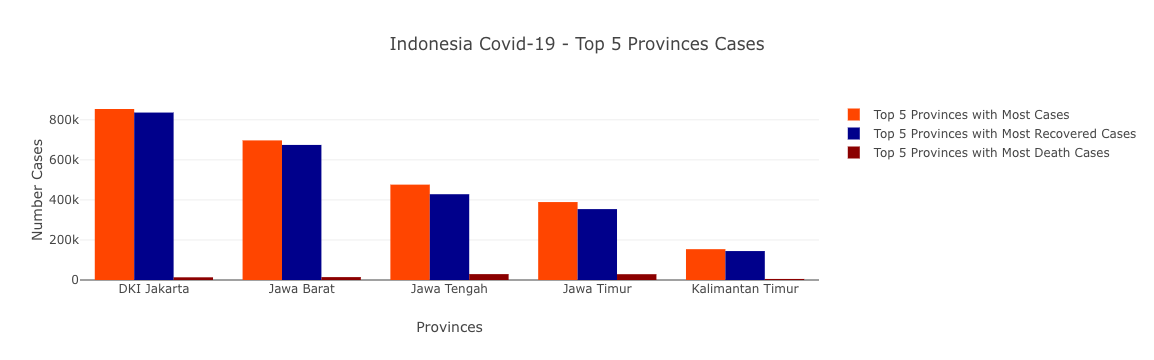

In [17]:
let layout = Layout::new()
    .title(Title::new("Indonesia Covid-19 - Top 5 Provinces Cases"))
    .x_axis(Axis::new().title(Title::new("Provinces")))
    .y_axis(Axis::new().title(Title::new("Number Cases")));

let mut bar_plot = Plot::new();
bar_plot.set_layout(layout);
bar_plot.add_trace(top_cases_trace);
bar_plot.add_trace(top_recovered_trace);
bar_plot.add_trace(top_death_trace);
bar_plot.lab_display()

## **Analyze Data Based `Location Level: Country`**

In [18]:
let countries = df.filter(&df.column("Location Level").unwrap().equal("Country")).unwrap();

In [19]:
let countries_new_cases = countries
    .column("New Cases")
    .unwrap()
    .i64()
    .unwrap()
    .to_ndarray()
    .unwrap().to_owned();
println!("{:?}", countries_new_cases);

[2, 0, 0, 0, 2, ..., 176, 297, 278, 311, 245], shape=[642], strides=[1], layout=CFcf (0xf), const ndim=1


In [20]:
let countries_new_deaths = countries
    .column("New Deaths")
    .unwrap()
    .i64()
    .unwrap()
    .to_ndarray()
    .unwrap()
    .to_owned();
println!("{:?}", countries_new_deaths);

[0, 0, 0, 0, 0, ..., 11, 11, 10, 10, 8], shape=[642], strides=[1], layout=CFcf (0xf), const ndim=1


In [21]:
let countries_new_recovered = countries
    .column("New Recovered")
    .unwrap()
    .i64()
    .unwrap()
    .to_ndarray()
    .unwrap()
    .to_owned();
println!("{:?}", countries_new_recovered);

[0, 0, 0, 0, 0, ..., 419, 324, 307, 388, 328], shape=[642], strides=[1], layout=CFcf (0xf), const ndim=1


#### Scatter plot Trace Data & Display `(Based: New Cases)`

In [22]:
let new_vs_death_trace = Scatter::from_array(
        countries_new_cases.to_owned(),
        countries_new_deaths.to_owned(),
    )
.mode(Mode::MarkersText)
.name("New Cases vs New Death Cases");

let new_vs_recovered_trace = Scatter::from_array(
    countries_new_cases.to_owned(),
    countries_new_recovered.to_owned(),
)
.mode(Mode::MarkersText)
.name("New Case vs New Recovered Cases");

let death_vs_recovered_trace = Scatter::from_array(
    countries_new_deaths.to_owned(),
    countries_new_recovered.to_owned(),
)
.mode(Mode::MarkersText)
.name("New Death vs New Recovered Cases");

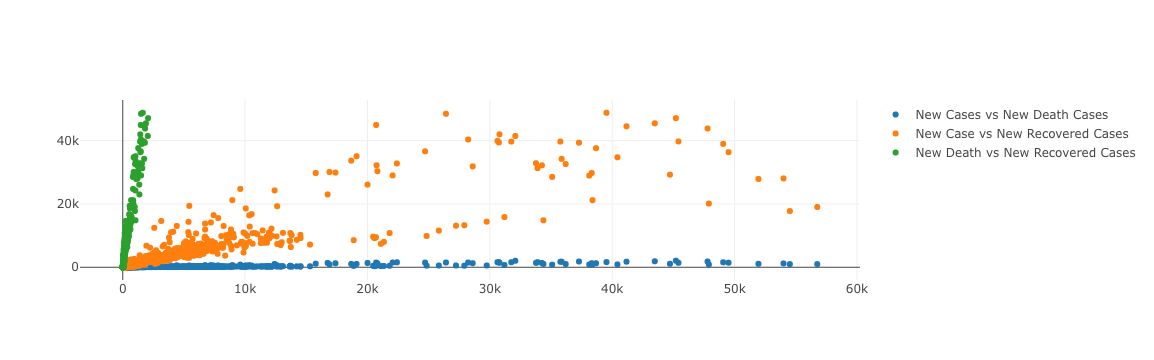

In [23]:
let mut scatter_plot = Plot::new();
scatter_plot.add_trace(new_vs_death_trace);
scatter_plot.add_trace(new_vs_recovered_trace);
scatter_plot.add_trace(death_vs_recovered_trace);
scatter_plot.lab_display()

#### Scatter plot Trace Data & Display `(Based: Total Cases)`

In [24]:
let countries_ttl_cases = countries
    .column("Total Cases")
    .unwrap()
    .i64()
    .unwrap()
    .to_ndarray()
    .unwrap().to_owned();
println!("{:?}", countries_ttl_cases);

[2, 2, 2, 2, 4, ..., 4256112, 4256409, 4256687, 4256998, 4257243], shape=[642], strides=[1], layout=CFcf (0xf), const ndim=1


In [25]:
let countries_ttl_deaths = countries
    .column("Total Deaths")
    .unwrap()
    .i64()
    .unwrap()
    .to_ndarray()
    .unwrap()
    .to_owned();
println!("{:?}", countries_ttl_deaths);

[0, 0, 0, 0, 0, ..., 143819, 143830, 143840, 143850, 143858], shape=[642], strides=[1], layout=CFcf (0xf), const ndim=1


In [26]:
let countries_ttl_recovered = countries
    .column("Total Recovered")
    .unwrap()
    .i64()
    .unwrap()
    .to_ndarray()
    .unwrap()
    .to_owned();
println!("{:?}", countries_ttl_recovered);

[0, 0, 0, 0, 0, ..., 4104333, 4104657, 4104964, 4105352, 4105680], shape=[642], strides=[1], layout=CFcf (0xf), const ndim=1


In [27]:
let ttl_case_vs_ttl_death_trace = Scatter::from_array(
        countries_ttl_cases.to_owned(),
        countries_ttl_deaths.to_owned(),
    )
.mode(Mode::MarkersText)
.name("Total Cases vs Total Death Cases");

let ttl_case_vs_ttl_recovered_trace = Scatter::from_array(
    countries_ttl_cases.to_owned(),
    countries_ttl_recovered.to_owned(),
)
.mode(Mode::MarkersText)
.name("Total Case vs Total Recovered Cases");

let ttl_death_vs_ttl_recovered_trace = Scatter::from_array(
    countries_ttl_deaths.to_owned(),
    countries_ttl_recovered.to_owned(),
)
.mode(Mode::MarkersText)
.name("Total Death vs Total Recovered Cases");

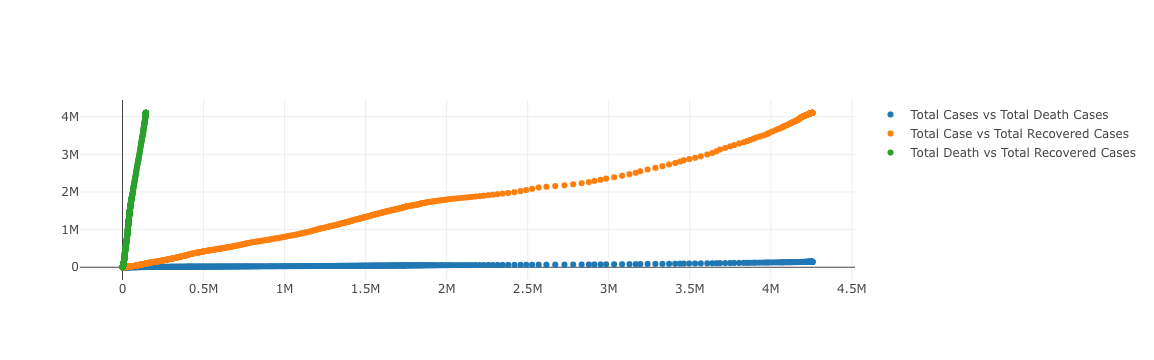

In [28]:
let mut ttl_scatter_plot = Plot::new();
ttl_scatter_plot.add_trace(ttl_case_vs_ttl_death_trace);
ttl_scatter_plot.add_trace(ttl_case_vs_ttl_recovered_trace);
ttl_scatter_plot.add_trace(ttl_death_vs_ttl_recovered_trace);
ttl_scatter_plot.lab_display()